In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Loading the Dataset and checking it's contents and checking the data quality

In [61]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [62]:
# Checking it's Shape
df.shape

(730, 16)

In [63]:
# Checking if instant column has unique entries, if yes, then will convert it to index
df['instant'].nunique()

730

In [64]:
# Setting the instant column as index to number of columns
df.set_index('instant', inplace=True)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Since the Model is to be built for <b>cnt</b> column, <b>casual</b> and <b>registed</b> are redundant here. It should not be used to build the model, thus dropping these two columns before further processing.

In [65]:
df.drop(['casual', 'registered'], inplace=True, axis = 1)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [66]:
# Checking Columns Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 79.8+ KB


In [67]:
# Converting the dtedat to Date Time
df['dteday'] = pd.to_datetime(df['dteday'])
df['dteday'].dtypes

dtype('<M8[ns]')

In [68]:
# Changing the month number to month abbr for better view
import calendar
df['mnth'] = df['mnth'].apply(lambda x: calendar.month_abbr[x])
df['mnth'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [69]:
# Since season, weekday and weathesit are basically categorical values, converting them to string type for future use
df[['season','weekday','weathersit']] = df[['season','weekday','weathersit']].astype(str)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    object        
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    object        
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    object        
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    object        
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(4)
memory usage: 79.8+ KB


In [71]:
# Checking the % of null values in each column
round(df.isnull().sum()/len(df.index)*100,2)

dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
cnt           0.0
dtype: float64

There are no Null values!

In [72]:
# Checking the range of values, for example temperature, humidity etc
df[['temp', 'atemp', 'hum', 'windspeed']].describe()

,temp,atemp,hum,windspeed
count,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620
std,7.506729,8.150308,14.237589,5.195841
min,2.424346,3.953480,0.000000,1.500244
25%,13.811885,16.889713,52.000000,9.041650
50%,20.465826,24.368225,62.625000,12.125325
75%,26.880615,30.445775,72.989575,15.625589
max,35.328347,42.044800,97.250000,34.000021


In [73]:
# Converting the weather variable into more understanable text
df['weathersit'].replace(['1','2','3','4'],['Good', 'Average', 'Bad', 'Very Bad'], inplace=True)

In [74]:
# Converting the seasons into specific season names for better understanding
df['season'].replace(['1','2','3','4'],['spring', 'summer', 'fall', 'winter'], inplace=True)

### Visualizing the data

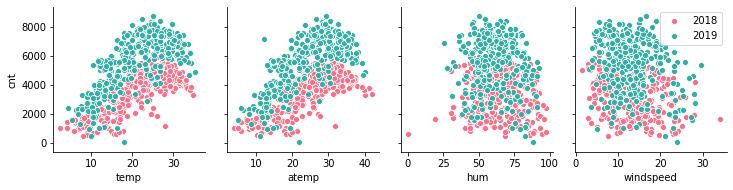

In [75]:
# Checking linear relationship between the cnt variable and other numeric variables
x =sns.pairplot(df, palette='husl', x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars=['cnt'] , hue='yr' )
x._legend.remove()
plt.legend(labels=['2018', '2019'])
plt.show()

We can see that there is some corelation between Feeling Temperature and sales. Also the count in 2019 are much higher than the count in 2018 for all circumstances.

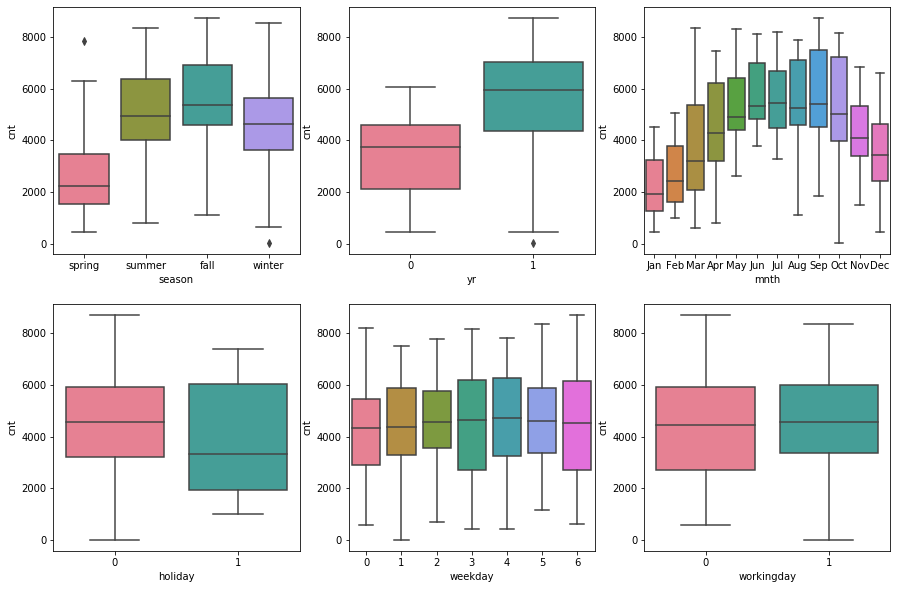

In [83]:
# Checking the distribution of rentals across different categorical variables
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.boxplot(x='season', y='cnt', data=df, palette='husl')
plt.subplot(2,3,2)
sns.boxplot(x='yr', y='cnt', data=df, palette='husl')
plt.subplot(2,3,3)
sns.boxplot(x='mnth', y='cnt', data=df, palette='husl')
plt.subplot(2,3,4)
sns.boxplot(x='holiday', y='cnt', data=df, palette='husl')
plt.subplot(2,3,5)
sns.boxplot(x='weekday', y='cnt', data=df, palette='husl')
plt.subplot(2,3,6)
sns.boxplot(x='workingday', y='cnt', data=df, palette='husl')

plt.show()

It seems that during the summer months, the registration count picks up.

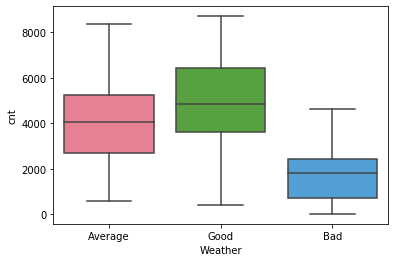

In [77]:
sns.boxplot(x='weathersit', y='cnt', data=df, palette='husl')
plt.xlabel('Weather')
plt.show()

Count picks up in Good Weather days

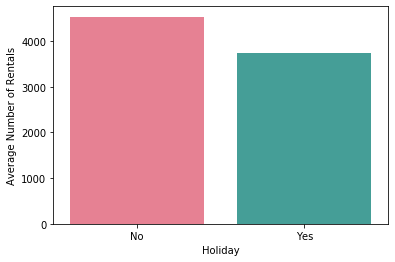

In [97]:
# Checking business on Holidays
holiday_df = df.groupby(['holiday'])['cnt'].mean().reset_index()
sns.barplot(x='holiday', y='cnt', data=holiday_df, palette='husl')
plt.xticks(np.arange(2),('No','Yes'))
plt.xlabel('Holiday')
plt.ylabel('Average Number of Rentals')
plt.show()

Non Holidays have slight higher average rentals

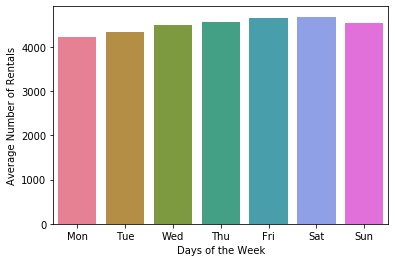

In [99]:
# Total rentals on different days of the week.
weekday_df = df.groupby(['weekday'])['cnt'].mean().reset_index()
sns.barplot(x='weekday', y='cnt', data=weekday_df, palette='husl')
plt.xticks(np.arange(7),('Mon','Tue','Wed','Thu', 'Fri', 'Sat', 'Sun'))
plt.xlabel('Days of the Week')
plt.ylabel('Average Number of Rentals')
plt.show()

Rentals are uniform throuout the week but there is a small uptrend as weekend appraches.

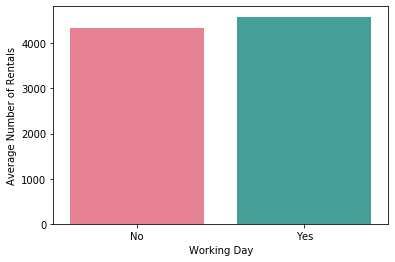

In [95]:
# Checking business on Workingdays
workingday_df = df.groupby(['workingday'])['cnt'].mean().reset_index()
sns.barplot(x='workingday', y='cnt', data=workingday_df, palette='husl')
plt.xticks(np.arange(2),('No','Yes'))
plt.xlabel('Working Day')
plt.ylabel('Average Number of Rentals')
plt.show()

### Creating Dummy Variables for Categorical Data
#### We need to create dummy variables for the following columns.
- season
- mnth
- weekday
- weathersit

In [19]:
dummy = pd.get_dummies(df[['season','mnth','weekday','weathersit']], drop_first=True)
dummy.head()

,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,...,mnth_Oct,mnth_Sep,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Bad,weathersit_Good
instant,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [20]:
df = pd.concat([df,dummy], axis=1)   #Axis=1 is for horizontal stacking
df = df.drop(['season','mnth','weekday','weathersit'], axis=1)
df.head()

,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,...,mnth_Oct,mnth_Sep,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Bad,weathersit_Good
instant,,,,,,,,,,,,,,,,,,,,,
1,2018-01-01,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,...,0,0,0,0,0,0,0,1,0,0
2,2018-02-01,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,...,0,0,0,0,0,0,0,0,0,0
3,2018-03-01,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,...,0,0,1,0,0,0,0,0,0,1
4,2018-04-01,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,...,0,0,0,1,0,0,0,0,0,1
5,2018-05-01,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,...,0,0,0,0,1,0,0,0,0,1


In [21]:
print('Shape of the new dataframe is:' , df.shape)

Shape of the new dataframe is: (730, 31)


In [22]:
# Since we have the month and the Year in two seperate columns, we do not need the date column anymore, thus dropping it
df.drop('dteday', inplace=True, axis = 1)

In [23]:
# Moving the cnt to the end for easier identification
first_col = df.pop('cnt')
df['cnt'] = first_col

### Splitting the data into Train and Test Dataset

In [24]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

In [25]:
print('Shape of the Train data is:' , df_train.shape)
print('Shape of the Test data is:' , df_test.shape)

Shape of the Train data is: (510, 30)
Shape of the Test data is: (220, 30)


In [26]:
# Checking the Train Data
pd.set_option('display.max_columns', None)
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Bad,weathersit_Good,cnt
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
577,1,0,1,29.246653,33.1448,70.4167,11.083475,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,7216
427,1,0,0,16.980847,20.6746,62.1250,10.792293,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4066
729,1,0,0,10.489153,11.5850,48.3333,23.500518,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1796
483,1,0,0,15.443347,18.8752,48.9583,8.708325,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4220
112,0,0,1,13.803347,16.0977,72.9583,14.707907,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1683


Other than the numeric fields, all other categorical values have been encoded. Now we can go ahead and scale the data.

### Feature Scaling

In [27]:
# We do a MinMax scaling
scaler = MinMaxScaler()    #Instantiating the object
cols = df_train.columns
df_train[cols] = scaler.fit_transform(df_train[cols])

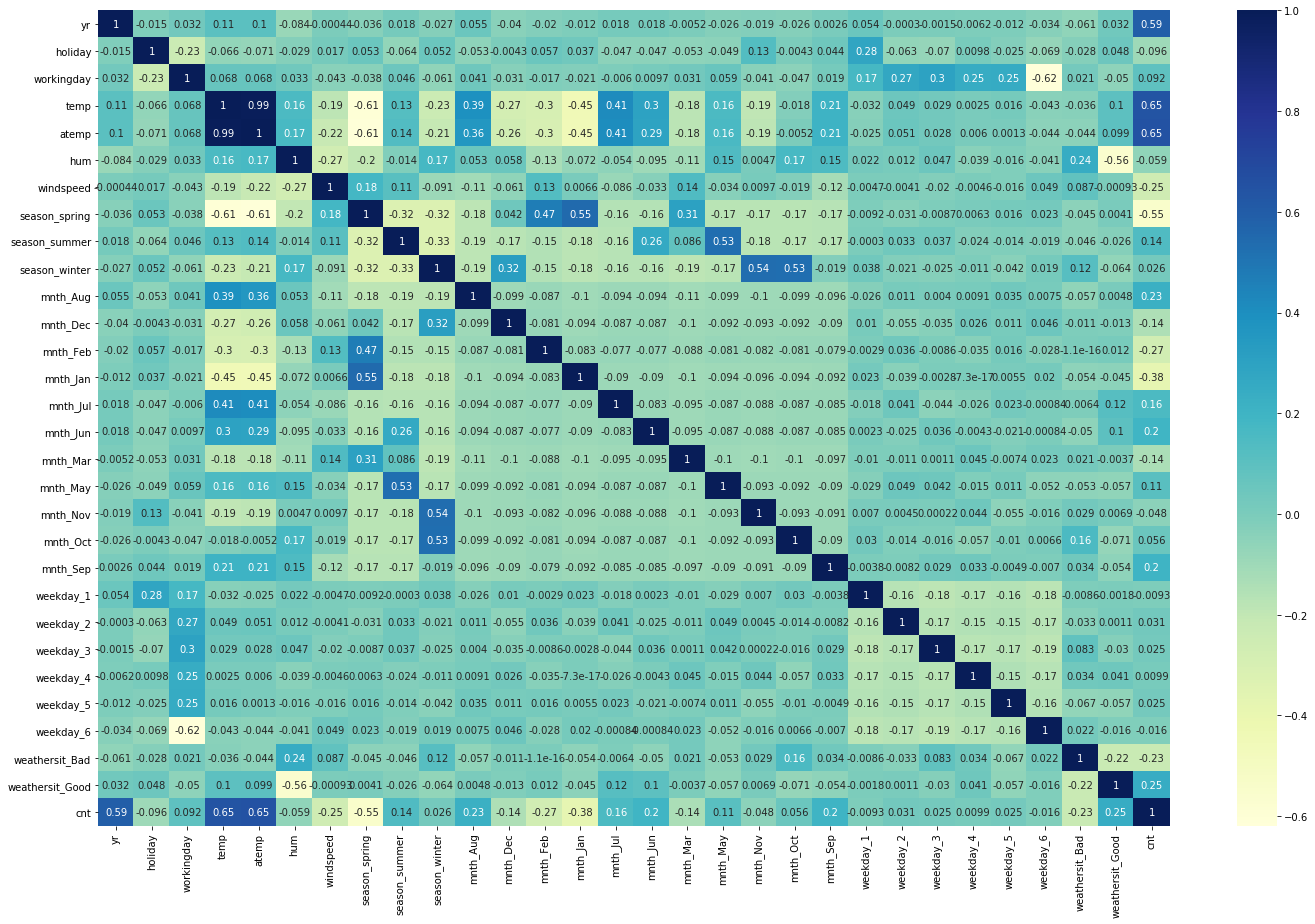

In [28]:
# Checking the Heatmap
plt.figure(figsize=(24,15))
sns.heatmap(df_train.corr(),annot=True, cmap='YlGnBu')
plt.show()

<b>cnt</b> has strong colinearity with <b>yr</b>, <b>temp</b>, <b>atemp</b>. <br> But, <b>temp</b> and <b>atemp</b> have almost a perfect colinearity, so both cannot be part of the model. We keep this in mind while building the model in the following cells.

### Building the Model
Since the number of columns is 29, which is manageable, we first build a model with all the columns, and then keep removing the columns based upon Statistical Significance and Co-Linearity.<br>
We will stop when we notice that there is no further improvement in the R2 value or all variables are statistically significant with low VIF.

<b>There wil be several iterations before getting the perfect model, so please bear with me!</b>

In [29]:
y_train = df_train.pop('cnt')
X_train = df_train
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model1 = lr.fit()
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.81e-180
Time:                        12:20:38   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2247      0.047      4.755      0.000       0.132       0.318
yr                  0.2325      0.008     28.794      0.000       0.217       0.248
holiday            -0.0416      0.024     -1.758      0.079      -0.088       0.005
workingday          0.0438      0.009      4.666      0.000       0.025       0.062
temp                0.3880      0.142      2.727      0.007       0.108       0.668
atemp               0.0590      0.138      0.426      0.670      -0.213       0.331
hum                -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed          -0.1836      0.026     -6.962      0.000      -0.235      -0.132
season_spring      -0.0454      0.030     -1.511      0.131      -0.104       0.014
season_summer       0.0424      0.026      1.617      0.107      -0.009       0.094
season_winter       0.1071      0.028      3.826      0.000       0.052       0.162
mnth_Aug            0.0223      0.034      0.657      0.511      -0.044       0.089
mnth_Dec           -0.0443      0.034     -1.316      0.189      -0.110       0.022
mnth_Feb           -0.0323      0.033     -0.980      0.327      -0.097       0.032
mnth_Jan           -0.0631      0.034     -1.876      0.061      -0.129       0.003
mnth_Jul           -0.0327      0.035     -0.931      0.352      -0.102       0.036
mnth_Jun            0.0060      0.025      0.241      0.810      -0.043       0.055
mnth_Mar            0.0016      0.025      0.063      0.950      -0.047       0.050
mnth_May            0.0255      0.021      1.208      0.228      -0.016       0.067
mnth_Nov           -0.0398      0.036     -1.093      0.275      -0.111       0.032
mnth_Oct            0.0077      0.036      0.215      0.830      -0.063       0.078
mnth_Sep            0.0868      0.032      2.711      0.007       0.024       0.150
weekday_1          -0.0101      0.010     -1.033      0.302      -0.029       0.009
weekday_2          -0.0069      0.011     -0.616      0.538      -0.029       0.015
weekday_3           0.0057      0.011      0.538      0.591      -0.015       0.026
weekday_4           0.0018      0.011      0.168      0.867      -0.020       0.023
weekday_5           0.0116      0.011      1.029      0.304      -0.011       0.034
weekday_6           0.0542      0.015      3.729      0.000       0.026       0.083
weathersit_Bad     -0.1955      0.025     -7.787      0.000      -0.245      -0.146
weathersit_Good     0.0595      0.010      5.701      0.000       0.039       0.080
==============================================================================
Omnibus:                       84.490   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.656
Skew:                          -0.805   Prob(JB):                     1.11

In [30]:
# Checking VIF (Variance Inflation Factor - MultiColinearity)
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
21,weekday_1,inf
23,weekday_3,inf
25,weekday_5,inf
1,holiday,inf
22,weekday_2,inf
24,weekday_4,inf
2,workingday,inf
3,temp,440.24
4,atemp,383.65
5,hum,33.71


The R-squared is a significant 85%, but there are insignificant variables and variables with strong multicollinearity. We need to get rid of them, in the following cells, we will follow the same process in an itrative manner till we build a robust model. First we will remove all columns with High P Values and then when the P Values are acceptable for all the columns, we will check their VIF and remove them.

In [31]:
# Removing 'mnth_Mar' due to high P-Value
X = X_train.drop('mnth_Mar',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model2 = lr.fit()
lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.75e-181
Time:                        12:20:38   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -998.2
Df Residuals:                     482   BIC:                            -879.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2257      0.045      5.044      0.000       0.138       0.314
yr                  0.2325      0.008     28.824      0.000       0.217       0.248
holiday            -0.0416      0.024     -1.760      0.079      -0.088       0.005
workingday          0.0438      0.009      4.680      0.000       0.025       0.062
temp                0.3877      0.142      2.729      0.007       0.109       0.667
atemp               0.0588      0.138      0.425      0.671      -0.213       0.330
hum                -0.1518      0.038     -3.950      0.000      -0.227      -0.076
windspeed          -0.1837      0.026     -6.983      0.000      -0.235      -0.132
season_spring      -0.0447      0.028     -1.575      0.116      -0.101       0.011
season_summer       0.0421      0.026      1.637      0.102      -0.008       0.093
season_winter       0.1074      0.027      3.910      0.000       0.053       0.161
mnth_Aug            0.0216      0.032      0.676      0.499      -0.041       0.084
mnth_Dec           -0.0456      0.026     -1.755      0.080      -0.097       0.005
mnth_Feb           -0.0338      0.022     -1.517      0.130      -0.078       0.010
mnth_Jan           -0.0646      0.022     -2.892      0.004      -0.109      -0.021
mnth_Jul           -0.0333      0.033     -0.999      0.318      -0.099       0.032
mnth_Jun            0.0055      0.024      0.233      0.816      -0.041       0.052
mnth_May            0.0251      0.020      1.268      0.205      -0.014       0.064
mnth_Nov           -0.0410      0.031     -1.333      0.183      -0.102       0.019
mnth_Oct            0.0065      0.031      0.213      0.831      -0.054       0.067
mnth_Sep            0.0859      0.029      2.961      0.003       0.029       0.143
weekday_1          -0.0101      0.010     -1.034      0.302      -0.029       0.009
weekday_2          -0.0069      0.011     -0.617      0.538      -0.029       0.015
weekday_3           0.0057      0.011      0.539      0.590      -0.015       0.026
weekday_4           0.0019      0.011      0.171      0.864      -0.020       0.023
weekday_5           0.0116      0.011      1.030      0.304      -0.010       0.034
weekday_6           0.0543      0.015      3.737      0.000       0.026       0.083
weathersit_Bad     -0.1954      0.025     -7.795      0.000      -0.245      -0.146
weathersit_Good     0.0595      0.010      5.708      0.000       0.039       0.080
==============================================================================
Omnibus:                       84.449   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.878
Skew:                          -0.804   Prob(JB):                     9.93e-52
Kurtosis:                       5.910   Cond. No.                     1.20e+16


In [32]:
# Removing 'weekday_4' due to high P-Value
X = X.drop('weekday_4',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model3 = lr.fit()
lr_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.75e-181
Time:                        12:20:38   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -998.2
Df Residuals:                     482   BIC:                            -879.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2257      0.045      5.044      0.000       0.138       0.314
yr                  0.2325      0.008     28.824      0.000       0.217       0.248
holiday            -0.0398      0.030     -1.323      0.186      -0.099       0.019
workingday          0.0456      0.015      3.019      0.003       0.016       0.075
temp                0.3877      0.142      2.729      0.007       0.109       0.667
atemp               0.0588      0.138      0.425      0.671      -0.213       0.330
hum                -0.1518      0.038     -3.950      0.000      -0.227      -0.076
windspeed          -0.1837      0.026     -6.983      0.000      -0.235      -0.132
season_spring      -0.0447      0.028     -1.575      0.116      -0.101       0.011
season_summer       0.0421      0.026      1.637      0.102      -0.008       0.093
season_winter       0.1074      0.027      3.910      0.000       0.053       0.161
mnth_Aug            0.0216      0.032      0.676      0.499      -0.041       0.084
mnth_Dec           -0.0456      0.026     -1.755      0.080      -0.097       0.005
mnth_Feb           -0.0338      0.022     -1.517      0.130      -0.078       0.010
mnth_Jan           -0.0646      0.022     -2.892      0.004      -0.109      -0.021
mnth_Jul           -0.0333      0.033     -0.999      0.318      -0.099       0.032
mnth_Jun            0.0055      0.024      0.233      0.816      -0.041       0.052
mnth_May            0.0251      0.020      1.268      0.205      -0.014       0.064
mnth_Nov           -0.0410      0.031     -1.333      0.183      -0.102       0.019
mnth_Oct            0.0065      0.031      0.213      0.831      -0.054       0.067
mnth_Sep            0.0859      0.029      2.961      0.003       0.029       0.143
weekday_1          -0.0119      0.015     -0.788      0.431      -0.042       0.018
weekday_2          -0.0087      0.015     -0.568      0.570      -0.039       0.022
weekday_3           0.0038      0.015      0.259      0.796      -0.025       0.033
weekday_5           0.0097      0.016      0.622      0.535      -0.021       0.040
weekday_6           0.0543      0.015      3.737      0.000       0.026       0.083
weathersit_Bad     -0.1954      0.025     -7.795      0.000      -0.245      -0.146
weathersit_Good     0.0595      0.010      5.708      0.000       0.039       0.080
==============================================================================
Omnibus:                       84.449   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.878
Skew:                          -0.804   Prob(JB):                     9.93e-52
Kurtosis:                       5.910   Cond. No.                         95.3
==============================================================================

Warn

In [33]:
# Removing 'mnth_Oct' due to high P-Value
X = X.drop('mnth_Oct',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model4 = lr.fit()
lr_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     107.4
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.68e-182
Time:                        12:20:38   Log-Likelihood:                 527.10
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     483   BIC:                            -885.9
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2274      0.044      5.166      0.000       0.141       0.314
yr                  0.2325      0.008     28.873      0.000       0.217       0.248
holiday            -0.0394      0.030     -1.316      0.189      -0.098       0.019
workingday          0.0455      0.015      3.016      0.003       0.016       0.075
temp                0.3882      0.142      2.736      0.006       0.109       0.667
atemp               0.0589      0.138      0.427      0.670      -0.212       0.330
hum                -0.1511      0.038     -3.951      0.000      -0.226      -0.076
windspeed          -0.1835      0.026     -6.986      0.000      -0.235      -0.132
season_spring      -0.0460      0.028     -1.655      0.099      -0.101       0.009
season_summer       0.0400      0.024      1.684      0.093      -0.007       0.087
season_winter       0.1101      0.024      4.539      0.000       0.062       0.158
mnth_Aug            0.0190      0.029      0.644      0.520      -0.039       0.077
mnth_Dec           -0.0495      0.018     -2.687      0.007      -0.086      -0.013
mnth_Feb           -0.0349      0.022     -1.608      0.108      -0.078       0.008
mnth_Jan           -0.0657      0.022     -3.010      0.003      -0.109      -0.023
mnth_Jul           -0.0360      0.031     -1.161      0.246      -0.097       0.025
mnth_Jun            0.0043      0.023      0.187      0.852      -0.041       0.049
mnth_May            0.0246      0.020      1.253      0.211      -0.014       0.063
mnth_Nov           -0.0462      0.019     -2.426      0.016      -0.084      -0.009
mnth_Sep            0.0827      0.025      3.336      0.001       0.034       0.131
weekday_1          -0.0119      0.015     -0.791      0.429      -0.042       0.018
weekday_2          -0.0088      0.015     -0.569      0.570      -0.039       0.021
weekday_3           0.0038      0.015      0.261      0.794      -0.025       0.033
weekday_5           0.0097      0.016      0.625      0.532      -0.021       0.040
weekday_6           0.0542      0.014      3.738      0.000       0.026       0.083
weathersit_Bad     -0.1952      0.025     -7.800      0.000      -0.244      -0.146
weathersit_Good     0.0596      0.010      5.721      0.000       0.039       0.080
==============================================================================
Omnibus:                       83.679   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.048
Skew:                          -0.799   Prob(JB):                     6.74e-51
Kurtosis:                       5.884   Cond. No.                         95.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [34]:
# Removing 'mnth_Jun' due to high P-Value
X = X.drop('mnth_Jun',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model5 = lr.fit()
lr_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     112.0
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.55e-183
Time:                        12:20:38   Log-Likelihood:                 527.08
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     484   BIC:                            -892.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2279      0.044      5.193      0.000       0.142       0.314
yr                  0.2323      0.008     29.009      0.000       0.217       0.248
holiday            -0.0399      0.030     -1.339      0.181      -0.099       0.019
workingday          0.0454      0.015      3.014      0.003       0.016       0.075
temp                0.3961      0.135      2.926      0.004       0.130       0.662
atemp               0.0554      0.137      0.405      0.685      -0.213       0.324
hum                -0.1520      0.038     -4.015      0.000      -0.226      -0.078
windspeed          -0.1841      0.026     -7.081      0.000      -0.235      -0.133
season_spring      -0.0474      0.027     -1.771      0.077      -0.100       0.005
season_summer       0.0393      0.023      1.677      0.094      -0.007       0.085
season_winter       0.1086      0.023      4.756      0.000       0.064       0.153
mnth_Aug            0.0157      0.024      0.662      0.508      -0.031       0.062
mnth_Dec           -0.0490      0.018     -2.690      0.007      -0.085      -0.013
mnth_Feb           -0.0343      0.021     -1.599      0.110      -0.077       0.008
mnth_Jan           -0.0648      0.021     -3.045      0.002      -0.107      -0.023
mnth_Jul           -0.0394      0.025     -1.598      0.111      -0.088       0.009
mnth_May            0.0229      0.017      1.319      0.188      -0.011       0.057
mnth_Nov           -0.0459      0.019     -2.421      0.016      -0.083      -0.009
mnth_Sep            0.0804      0.021      3.744      0.000       0.038       0.123
weekday_1          -0.0118      0.015     -0.785      0.433      -0.041       0.018
weekday_2          -0.0088      0.015     -0.570      0.569      -0.039       0.021
weekday_3           0.0039      0.015      0.266      0.790      -0.025       0.033
weekday_5           0.0097      0.016      0.624      0.533      -0.021       0.040
weekday_6           0.0542      0.014      3.743      0.000       0.026       0.083
weathersit_Bad     -0.1953      0.025     -7.814      0.000      -0.244      -0.146
weathersit_Good     0.0595      0.010      5.725      0.000       0.039       0.080
==============================================================================
Omnibus:                       83.300   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.416
Skew:                          -0.798   Prob(JB):                     2.51e-50
Kurtosis:                       5.864   Cond. No.                         92.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
# Removing 'weekday_3' due to high P-Value
X = X.drop('weekday_3',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model6 = lr.fit()
lr_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     116.8
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.42e-184
Time:                        12:20:38   Log-Likelihood:                 527.04
No. Observations:                 510   AIC:                            -1004.
Df Residuals:                     485   BIC:                            -898.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2275      0.044      5.192      0.000       0.141       0.314
yr                  0.2323      0.008     29.038      0.000       0.217       0.248
holiday            -0.0381      0.029     -1.314      0.190      -0.095       0.019
workingday          0.0476      0.013      3.723      0.000       0.022       0.073
temp                0.3975      0.135      2.941      0.003       0.132       0.663
atemp               0.0542      0.136      0.397      0.692      -0.214       0.322
hum                -0.1517      0.038     -4.013      0.000      -0.226      -0.077
windspeed          -0.1842      0.026     -7.092      0.000      -0.235      -0.133
season_spring      -0.0472      0.027     -1.768      0.078      -0.100       0.005
season_summer       0.0394      0.023      1.687      0.092      -0.006       0.085
season_winter       0.1088      0.023      4.772      0.000       0.064       0.154
mnth_Aug            0.0157      0.024      0.664      0.507      -0.031       0.062
mnth_Dec           -0.0492      0.018     -2.703      0.007      -0.085      -0.013
mnth_Feb           -0.0342      0.021     -1.594      0.112      -0.076       0.008
mnth_Jan           -0.0647      0.021     -3.045      0.002      -0.106      -0.023
mnth_Jul           -0.0394      0.025     -1.598      0.111      -0.088       0.009
mnth_May            0.0229      0.017      1.322      0.187      -0.011       0.057
mnth_Nov           -0.0460      0.019     -2.431      0.015      -0.083      -0.009
mnth_Sep            0.0804      0.021      3.748      0.000       0.038       0.123
weekday_1          -0.0139      0.013     -1.081      0.280      -0.039       0.011
weekday_2          -0.0109      0.013     -0.831      0.406      -0.037       0.015
weekday_5           0.0076      0.013      0.569      0.570      -0.019       0.034
weekday_6           0.0542      0.014      3.747      0.000       0.026       0.083
weathersit_Bad     -0.1953      0.025     -7.819      0.000      -0.244      -0.146
weathersit_Good     0.0594      0.010      5.728      0.000       0.039       0.080
==============================================================================
Omnibus:                       83.679   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.837
Skew:                          -0.801   Prob(JB):                     1.23e-50
Kurtosis:                       5.872   Cond. No.                         92.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Removing 'atemp' due to high P-Value
X = X.drop('atemp',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model7 = lr.fit()
lr_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     122.1
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.34e-185
Time:                        12:20:38   Log-Likelihood:                 526.96
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     486   BIC:                            -904.3
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2274      0.044      5.194      0.000       0.141       0.313
yr                  0.2323      0.008     29.061      0.000       0.217       0.248
holiday            -0.0387      0.029     -1.335      0.183      -0.096       0.018
workingday          0.0476      0.013      3.728      0.000       0.023       0.073
temp                0.4489      0.038     11.686      0.000       0.373       0.524
hum                -0.1510      0.038     -4.002      0.000      -0.225      -0.077
windspeed          -0.1863      0.025     -7.322      0.000      -0.236      -0.136
season_spring      -0.0465      0.027     -1.745      0.082      -0.099       0.006
season_summer       0.0403      0.023      1.731      0.084      -0.005       0.086
season_winter       0.1097      0.023      4.841      0.000       0.065       0.154
mnth_Aug            0.0150      0.024      0.635      0.525      -0.031       0.061
mnth_Dec           -0.0491      0.018     -2.701      0.007      -0.085      -0.013
mnth_Feb           -0.0342      0.021     -1.597      0.111      -0.076       0.008
mnth_Jan           -0.0650      0.021     -3.060      0.002      -0.107      -0.023
mnth_Jul           -0.0394      0.025     -1.600      0.110      -0.088       0.009
mnth_May            0.0227      0.017      1.310      0.191      -0.011       0.057
mnth_Nov           -0.0460      0.019     -2.431      0.015      -0.083      -0.009
mnth_Sep            0.0804      0.021      3.752      0.000       0.038       0.123
weekday_1          -0.0138      0.013     -1.069      0.286      -0.039       0.012
weekday_2          -0.0109      0.013     -0.830      0.407      -0.037       0.015
weekday_5           0.0071      0.013      0.538      0.591      -0.019       0.033
weekday_6           0.0542      0.014      3.750      0.000       0.026       0.083
weathersit_Bad     -0.1960      0.025     -7.879      0.000      -0.245      -0.147
weathersit_Good     0.0595      0.010      5.739      0.000       0.039       0.080
==============================================================================
Omnibus:                       83.044   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.832
Skew:                          -0.795   Prob(JB):                     3.36e-50
Kurtosis:                       5.862   Cond. No.                         28.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Removing 'weekday_5' due to high P-Value
X = X.drop('weekday_5',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model8 = lr.fit()
lr_model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     127.9
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.36e-186
Time:                        12:20:38   Log-Likelihood:                 526.81
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     487   BIC:                            -910.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2284      0.044      5.227      0.000       0.143       0.314
yr                  0.2322      0.008     29.077      0.000       0.217       0.248
holiday            -0.0363      0.029     -1.268      0.205      -0.092       0.020
workingday          0.0498      0.012      4.116      0.000       0.026       0.074
temp                0.4484      0.038     11.686      0.000       0.373       0.524
hum                -0.1516      0.038     -4.024      0.000      -0.226      -0.078
windspeed          -0.1863      0.025     -7.327      0.000      -0.236      -0.136
season_spring      -0.0466      0.027     -1.753      0.080      -0.099       0.006
season_summer       0.0401      0.023      1.726      0.085      -0.006       0.086
season_winter       0.1099      0.023      4.851      0.000       0.065       0.154
mnth_Aug            0.0152      0.024      0.645      0.520      -0.031       0.062
mnth_Dec           -0.0492      0.018     -2.709      0.007      -0.085      -0.014
mnth_Feb           -0.0340      0.021     -1.590      0.112      -0.076       0.008
mnth_Jan           -0.0650      0.021     -3.066      0.002      -0.107      -0.023
mnth_Jul           -0.0389      0.025     -1.583      0.114      -0.087       0.009
mnth_May            0.0228      0.017      1.317      0.188      -0.011       0.057
mnth_Nov           -0.0466      0.019     -2.472      0.014      -0.084      -0.010
mnth_Sep            0.0803      0.021      3.747      0.000       0.038       0.122
weekday_1          -0.0160      0.012     -1.310      0.191      -0.040       0.008
weekday_2          -0.0131      0.012     -1.052      0.293      -0.037       0.011
weekday_6           0.0542      0.014      3.752      0.000       0.026       0.083
weathersit_Bad     -0.1974      0.025     -7.983      0.000      -0.246      -0.149
weathersit_Good     0.0591      0.010      5.719      0.000       0.039       0.079
==============================================================================
Omnibus:                       82.702   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.333
Skew:                          -0.792   Prob(JB):                     4.32e-50
Kurtosis:                       5.862   Cond. No.                         28.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Removing 'mnth_Aug' due to high P-Value
X = X.drop('mnth_Aug',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model9 = lr.fit()
lr_model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.1
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.47e-187
Time:                        12:20:38   Log-Likelihood:                 526.59
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     488   BIC:                            -916.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2370      0.042      5.700      0.000       0.155       0.319
yr                  0.2324      0.008     29.128      0.000       0.217       0.248
holiday            -0.0364      0.029     -1.275      0.203      -0.093       0.020
workingday          0.0499      0.012      4.130      0.000       0.026       0.074
temp                0.4502      0.038     11.769      0.000       0.375       0.525
hum                -0.1505      0.038     -4.001      0.000      -0.224      -0.077
windspeed          -0.1864      0.025     -7.338      0.000      -0.236      -0.137
season_spring      -0.0564      0.022     -2.576      0.010      -0.099      -0.013
season_summer       0.0298      0.017      1.766      0.078      -0.003       0.063
season_winter       0.1009      0.018      5.663      0.000       0.066       0.136
mnth_Dec           -0.0500      0.018     -2.758      0.006      -0.086      -0.014
mnth_Feb           -0.0340      0.021     -1.591      0.112      -0.076       0.008
mnth_Jan           -0.0650      0.021     -3.067      0.002      -0.107      -0.023
mnth_Jul           -0.0498      0.018     -2.770      0.006      -0.085      -0.014
mnth_May            0.0224      0.017      1.299      0.195      -0.012       0.056
mnth_Nov           -0.0476      0.019     -2.534      0.012      -0.085      -0.011
mnth_Sep            0.0716      0.017      4.303      0.000       0.039       0.104
weekday_1          -0.0160      0.012     -1.317      0.188      -0.040       0.008
weekday_2          -0.0129      0.012     -1.040      0.299      -0.037       0.011
weekday_6           0.0547      0.014      3.790      0.000       0.026       0.083
weathersit_Bad     -0.1985      0.025     -8.049      0.000      -0.247      -0.150
weathersit_Good     0.0588      0.010      5.703      0.000       0.039       0.079
==============================================================================
Omnibus:                       83.893   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.497
Skew:                          -0.803   Prob(JB):                     8.87e-51
Kurtosis:                       5.875   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# Removing 'weekday_2' due to high P-Value
X = X.drop('weekday_2',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model10 = lr.fit()
lr_model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     140.7
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          3.51e-188
Time:                        12:20:38   Log-Likelihood:                 526.03
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     489   BIC:                            -921.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2383      0.042      5.732      0.000       0.157       0.320
yr                  0.2323      0.008     29.122      0.000       0.217       0.248
holiday            -0.0389      0.029     -1.364      0.173      -0.095       0.017
workingday          0.0467      0.012      3.996      0.000       0.024       0.070
temp                0.4505      0.038     11.777      0.000       0.375       0.526
hum                -0.1518      0.038     -4.038      0.000      -0.226      -0.078
windspeed          -0.1869      0.025     -7.358      0.000      -0.237      -0.137
season_spring      -0.0562      0.022     -2.566      0.011      -0.099      -0.013
season_summer       0.0296      0.017      1.751      0.081      -0.004       0.063
season_winter       0.1004      0.018      5.639      0.000       0.065       0.135
mnth_Dec           -0.0492      0.018     -2.718      0.007      -0.085      -0.014
mnth_Feb           -0.0350      0.021     -1.636      0.102      -0.077       0.007
mnth_Jan           -0.0649      0.021     -3.062      0.002      -0.107      -0.023
mnth_Jul           -0.0507      0.018     -2.825      0.005      -0.086      -0.015
mnth_May            0.0222      0.017      1.285      0.199      -0.012       0.056
mnth_Nov           -0.0475      0.019     -2.525      0.012      -0.084      -0.011
mnth_Sep            0.0718      0.017      4.314      0.000       0.039       0.104
weekday_1          -0.0130      0.012     -1.102      0.271      -0.036       0.010
weekday_6           0.0545      0.014      3.779      0.000       0.026       0.083
weathersit_Bad     -0.1971      0.025     -8.005      0.000      -0.246      -0.149
weathersit_Good     0.0586      0.010      5.683      0.000       0.038       0.079
==============================================================================
Omnibus:                       84.077   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.009
Skew:                          -0.797   Prob(JB):                     5.64e-52
Kurtosis:                       5.926   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Removing 'weekday_1' due to high P-Value
X = X.drop('weekday_1',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model11 = lr.fit()
lr_model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     148.0
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          5.20e-189
Time:                        12:20:38   Log-Likelihood:                 525.39
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     490   BIC:                            -926.1
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2387      0.042      5.740      0.000       0.157       0.320
yr                  0.2318      0.008     29.103      0.000       0.216       0.247
holiday            -0.0492      0.027     -1.827      0.068      -0.102       0.004
workingday          0.0441      0.011      3.852      0.000       0.022       0.067
temp                0.4527      0.038     11.846      0.000       0.378       0.528
hum                -0.1538      0.038     -4.094      0.000      -0.228      -0.080
windspeed          -0.1873      0.025     -7.371      0.000      -0.237      -0.137
season_spring      -0.0553      0.022     -2.528      0.012      -0.098      -0.012
season_summer       0.0295      0.017      1.747      0.081      -0.004       0.063
season_winter       0.1001      0.018      5.618      0.000       0.065       0.135
mnth_Dec           -0.0488      0.018     -2.692      0.007      -0.084      -0.013
mnth_Feb           -0.0348      0.021     -1.626      0.105      -0.077       0.007
mnth_Jan           -0.0650      0.021     -3.067      0.002      -0.107      -0.023
mnth_Jul           -0.0510      0.018     -2.844      0.005      -0.086      -0.016
mnth_May            0.0229      0.017      1.325      0.186      -0.011       0.057
mnth_Nov           -0.0461      0.019     -2.456      0.014      -0.083      -0.009
mnth_Sep            0.0723      0.017      4.349      0.000       0.040       0.105
weekday_6           0.0544      0.014      3.774      0.000       0.026       0.083
weathersit_Bad     -0.1966      0.025     -7.983      0.000      -0.245      -0.148
weathersit_Good     0.0583      0.010      5.655      0.000       0.038       0.079
==============================================================================
Omnibus:                       82.971   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.033
Skew:                          -0.787   Prob(JB):                     2.50e-51
Kurtosis:                       5.914   Cond. No.                         26.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Removing 'mnth_May' due to high P-Value
X = X.drop('mnth_May',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model12 = lr.fit()
lr_model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     155.9
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          9.80e-190
Time:                        12:20:38   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1011.
Df Residuals:                     491   BIC:                            -930.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2283      0.041      5.586      0.000       0.148       0.309
yr                  0.2312      0.008     29.052      0.000       0.216       0.247
holiday            -0.0500      0.027     -1.855      0.064      -0.103       0.003
workingday          0.0442      0.011      3.860      0.000       0.022       0.067
temp                0.4616      0.038     12.262      0.000       0.388       0.536
hum                -0.1477      0.037     -3.958      0.000      -0.221      -0.074
windspeed          -0.1889      0.025     -7.441      0.000      -0.239      -0.139
season_spring      -0.0515      0.022     -2.373      0.018      -0.094      -0.009
season_summer       0.0393      0.015      2.586      0.010       0.009       0.069
season_winter       0.1021      0.018      5.752      0.000       0.067       0.137
mnth_Dec           -0.0474      0.018     -2.619      0.009      -0.083      -0.012
mnth_Feb           -0.0334      0.021     -1.562      0.119      -0.075       0.009
mnth_Jan           -0.0634      0.021     -2.991      0.003      -0.105      -0.022
mnth_Jul           -0.0515      0.018     -2.868      0.004      -0.087      -0.016
mnth_Nov           -0.0444      0.019     -2.371      0.018      -0.081      -0.008
mnth_Sep            0.0723      0.017      4.346      0.000       0.040       0.105
weekday_6           0.0540      0.014      3.743      0.000       0.026       0.082
weathersit_Bad     -0.1982      0.025     -8.054      0.000      -0.247      -0.150
weathersit_Good     0.0585      0.010      5.668      0.000       0.038       0.079
==============================================================================
Omnibus:                       80.597   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.714
Skew:                          -0.784   Prob(JB):                     3.91e-47
Kurtosis:                       5.757   Cond. No.                         25.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# Removing 'mnth_Feb' due to high P-Value
X = X.drop('mnth_Feb',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model13 = lr.fit()
lr_model13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.4
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          2.52e-190
Time:                        12:20:39   Log-Likelihood:                 523.22
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     492   BIC:                            -934.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2173      0.040      5.390      0.000       0.138       0.297
yr                  0.2309      0.008     28.978      0.000       0.215       0.247
holiday            -0.0520      0.027     -1.931      0.054      -0.105       0.001
workingday          0.0444      0.011      3.870      0.000       0.022       0.067
temp                0.4764      0.036     13.064      0.000       0.405       0.548
hum                -0.1494      0.037     -4.001      0.000      -0.223      -0.076
windspeed          -0.1879      0.025     -7.390      0.000      -0.238      -0.138
season_spring      -0.0607      0.021     -2.899      0.004      -0.102      -0.020
season_summer       0.0424      0.015      2.809      0.005       0.013       0.072
season_winter       0.1038      0.018      5.845      0.000       0.069       0.139
mnth_Dec           -0.0388      0.017     -2.248      0.025      -0.073      -0.005
mnth_Jan           -0.0455      0.018     -2.548      0.011      -0.081      -0.010
mnth_Jul           -0.0524      0.018     -2.916      0.004      -0.088      -0.017
mnth_Nov           -0.0399      0.019     -2.152      0.032      -0.076      -0.003
mnth_Sep            0.0737      0.017      4.430      0.000       0.041       0.106
weekday_6           0.0548      0.014      3.794      0.000       0.026       0.083
weathersit_Bad     -0.1972      0.025     -8.004      0.000      -0.246      -0.149
weathersit_Good     0.0583      0.010      5.637      0.000       0.038       0.079
==============================================================================
Omnibus:                       76.194   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.529
Skew:                          -0.745   Prob(JB):                     2.85e-44
Kurtosis:                       5.687   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We now see that all the variables have a P Value <= 0.05, which signifies that these variables are statistically significant. Let's now check if there is any Multi-Colinearity among these variables.

In [43]:
# Checking VIF (Variance Inflation Factor - MultiColinearity)
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,hum,26.35
3,temp,22.39
2,workingday,5.37
6,season_spring,5.11
5,windspeed,4.76
8,season_winter,4.37
16,weathersit_Good,3.56
7,season_summer,3.05
0,yr,2.09
14,weekday_6,2.00


Humidity and Temperature have a high VIF, which means they have multicolinearity and one of them must be removed and checked again.

In [44]:
# Removing 'hum' due to high VIF
X = X.drop('hum',axis=1)
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train, X_train_sm)
lr_model14 = lr.fit()
lr_model14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.6
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          4.83e-188
Time:                        12:20:39   Log-Likelihood:                 515.05
No. Observations:                 510   AIC:                            -996.1
Df Residuals:                     493   BIC:                            -924.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1219      0.033      3.694      0.000       0.057       0.187
yr                  0.2346      0.008     29.217      0.000       0.219       0.250
holiday            -0.0498      0.027     -1.822      0.069      -0.104       0.004
workingday          0.0474      0.012      4.080      0.000       0.025       0.070
temp                0.4370      0.036     12.260      0.000       0.367       0.507
windspeed          -0.1602      0.025     -6.452      0.000      -0.209      -0.111
season_spring      -0.0698      0.021     -3.304      0.001      -0.111      -0.028
season_summer       0.0356      0.015      2.339      0.020       0.006       0.066
season_winter       0.0901      0.018      5.095      0.000       0.055       0.125
mnth_Dec           -0.0458      0.017     -2.627      0.009      -0.080      -0.012
mnth_Jan           -0.0517      0.018     -2.864      0.004      -0.087      -0.016
mnth_Jul           -0.0475      0.018     -2.609      0.009      -0.083      -0.012
mnth_Nov           -0.0407      0.019     -2.162      0.031      -0.078      -0.004
mnth_Sep            0.0674      0.017      4.009      0.000       0.034       0.100
weekday_6           0.0596      0.015      4.080      0.000       0.031       0.088
weathersit_Bad     -0.2155      0.025     -8.764      0.000      -0.264      -0.167
weathersit_Good     0.0821      0.009      9.590      0.000       0.065       0.099
==============================================================================
Omnibus:                       79.557   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.036
Skew:                          -0.766   Prob(JB):                     1.23e-47
Kurtosis:                       5.796   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
#Checking the VIF Again
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,8.05
2,workingday,5.29
4,windspeed,4.74
5,season_spring,3.28
7,season_winter,3.02
15,weathersit_Good,2.86
6,season_summer,2.33
0,yr,2.08
13,weekday_6,1.98
11,mnth_Nov,1.84


This looks like an acceptable model. We keep the <b>temp</b> variable, because from our EDA, we have seen that Temperature has a direct colinearity with the booking count. On colder days, the bookings are less, whereas on hotter, summer time, the bookings are up significantly. Thus as per business understanding, we finalize this model as the final model.

In [46]:
# Checking the co-efficients of the final model lr_model14
print(lr_model14.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.6
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          4.83e-188
Time:                        12:20:39   Log-Likelihood:                 515.05
No. Observations:                 510   AIC:                            -996.1
Df Residuals:                     493   BIC:                            -924.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1219      0.033     

### Validating the assumptions of Linear Regression
- Linear Relationship
- Homoscedasticity
- Absence of Multicollinearity
- Independence of residuals (absence of auto-correlation)
- Normality of Errors

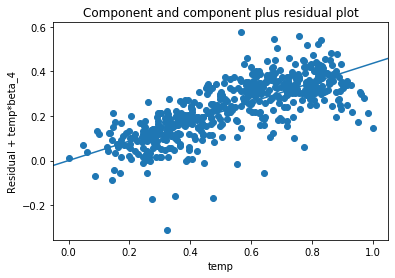

In [47]:
# Validating Linear Relationship
sm.graphics.plot_ccpr(lr_model14, 'temp')
plt.show()

The partial residual plot represents the relationship between the predictor and the dependent variable while taking into account all the other variables. As we can see in the above graph, the linearity is well respected.

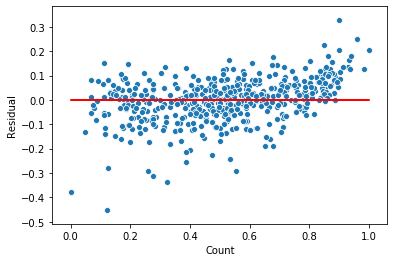

In [48]:
# Validating Homoscedasticity : The residuals have constant variance with respect to the dependent variable
y_train_pred = lr_model14.predict(X_train_sm)
sns.scatterplot(y_train,(y_train - y_train_pred))
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

As we can see in the above plot, Homoscedasticity is well respected since the variance of the residuals are almost constant.

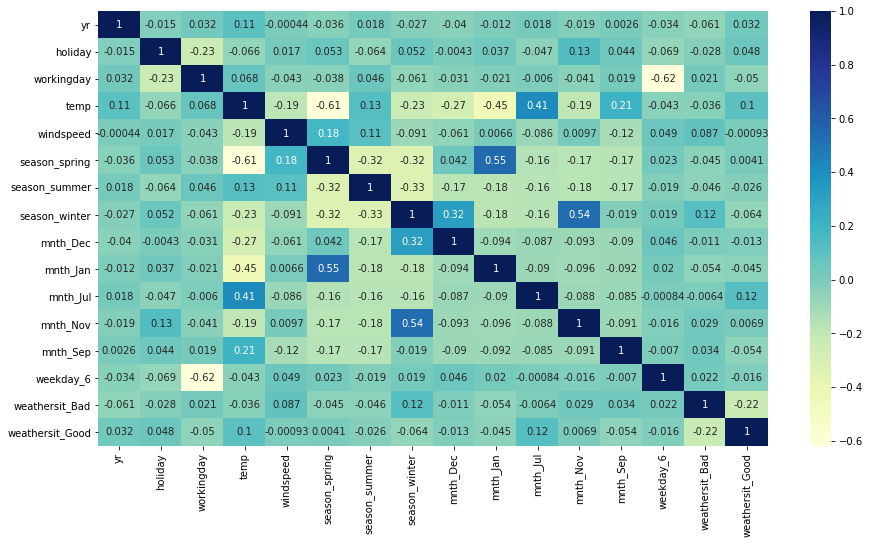

In [49]:
# Validating Multi Colinearity
plt.figure(figsize=(15,8))
sns.heatmap(X.corr(),annot=True, cmap='YlGnBu')
plt.show()

All variables have less than 0.56 correlation with eachother. Checking the VIF now.

In [50]:
print(vif)

           Features   VIF
3              temp  8.05
2        workingday  5.29
4         windspeed  4.74
5     season_spring  3.28
7     season_winter  3.02
15  weathersit_Good  2.86
6     season_summer  2.33
0                yr  2.08
13        weekday_6  1.98
11         mnth_Nov  1.84
9          mnth_Jan  1.67
10         mnth_Jul  1.60
8          mnth_Dec  1.50
12         mnth_Sep  1.36
1           holiday  1.20
14   weathersit_Bad  1.12


Taking 10 as the maximum VIF permissible for this model, we decide on keeping these colmns based upon business assumptions.

In [51]:
# Independence of residuals (absence of auto-correlation)
# Autocorrelation refers to the fact that observations’ errors are correlated
# To verify that the observations are not auto-correlated, we can use the Durbin-Watson test. 
# The test will output values between 0 and 4. The closer it is to 2, the less auto-correlation there is between the various variables
# (0–2: positive auto-correlation, 2–4: negative auto-correlation)

print('The Durbin-Watson value for Model No.14 is',round(sm.stats.stattools.durbin_watson((y_train - y_train_pred)),4))

The Durbin-Watson value for Model No.14 is 2.0445


There is almost nill auto-correlation

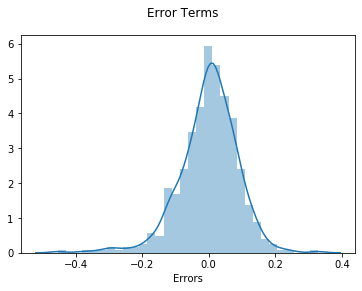

In [52]:
# Normality of Errors
y_train_pred = lr_model14.predict(X_train_sm)

# Ploting the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred))
fig.suptitle('Error Terms')                  
plt.xlabel('Errors')     
plt.show()

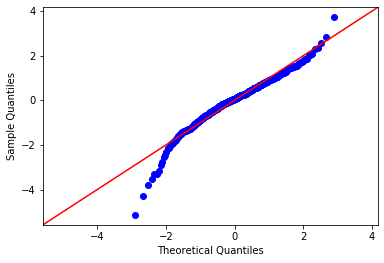

In [53]:
sm.qqplot((y_train - y_train_pred), fit=True, line='45')
plt.show()

The error terms are normally distributed

### Making prediction using the final model

In [54]:
# Scaling the Test Dataset with the Scaler of the Training Set
cols = df_test.columns
df_test[cols] = scaler.transform(df_test[cols])

In [55]:
# Dividing into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [56]:
# Adding the constant column
X_test_m14 = sm.add_constant(X_test)
# Removing all the columns which has been removed from Model 14
X_test_m14 = X_test_m14.drop(['hum','mnth_Feb','mnth_Mar','mnth_May',
                              'mnth_Jun','mnth_Aug','mnth_Oct','atemp',
                              'weekday_1','weekday_2','weekday_3','weekday_4','weekday_5' ], axis=1)

In [57]:
# Making prediction using Model 14
y_test_pred = lr_model14.predict(X_test_m14)

### Model Evaluation

In [58]:
print('The R-Squared score of the model for the predicted values is',round(r2_score(y_test, y_test_pred),2))
print('The Root Mean Squared Error of the model for the predicted values is',round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4))
print('The Mean Absolute Error of the model for the predicted values is',mean_absolute_error(y_test, y_test_pred))

The R-Squared score of the model for the predicted values is 0.82
The Root Mean Squared Error of the model for the predicted values is 0.0937
The Mean Absolute Error of the model for the predicted values is 0.07096599060208034


In [59]:
# As asked in problem statement
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.816207804545147

We can see that the equation of our best fitted line developed by Model 14 is:

$ cnt = 0.1219 + ( 0.2346  \times  yr - 0.0498  \times  holiday + 0.0474 \times workingday + 0.4370 \times temp - 0.1602 \times windspeed - 0.0698  \times season_spring + 0.0356 \times season_summer + 0.0901 \times season_winter - 0.0458 \times December - 0.0517 \times January - 0.0475 \times July -0.04078 \times November + 0.0674 \times September + 0.0596 \times weekday_6 - 0.2155 \times Bad Weather + 0.0821 \times Good Weather ) $


Since the bookings increase on good weather days with hotter temperature, the company must increase their bike availibilty and promotions during the summer months to further increase their booking count.

An R-Squared value of 0.82 on the test data signifies that the model is a very good predictor and 82% of the variance is captured by the model.It can be further improved by using other regression techniques like Random Forest.